# isogonal_hessian

> Study projection of cell-shape elasticity onto space of isogonal modes

In [ ]:
#| default_exp hss

In [ ]:
#| export

import CE_simulation.mesh as msh
import CE_simulation.tension as tns
import CE_simulation.delaunay as dln
import CE_simulation.isogonal as iso

In [ ]:
#| export
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy import optimize, ndimage, sparse

from tqdm.notebook import tqdm

from copy import deepcopy
import pickle

In [ ]:
#| export

from typing import Union, Dict, List, Tuple, Iterable, Callable, Any
from nptyping import NDArray, Int, Float, Shape

from fastcore.foundation import patch

In [ ]:
#| export

import jax.numpy as jnp
from jax import jit
import jax
from jax.tree_util import Partial

from jax.config import config
config.update("jax_enable_x64", True) # 32 bit leads the optimizer to complain about precision loss
config.update("jax_debug_nans", False) # useful for debugging, but makes code slower!

In [ ]:
#| export

import ipywidgets as widgets
import functools
from matplotlib import animation, rc

## Add methods to the HalfEdgeMesh class to compute isogonal modes

In [ ]:
#| export

@patch
def get_isogonal(self: msh.Vertex) -> Dict[int, NDArray[Shape["2"], Float]]:
    """
    Get isogonal mode for a given cell.
    
    Returns a dict: {faceid: translation vector} of primal vertices. Entries are
    
    j: T_j,bc / S_{self}bc
    
    where self,b,c are the three cells meeting at vertex j, and S is the area of the tension triangle.
    T_j is pointing towards vertex j (i.e. inwards)
    
    """

    # iterate over faces (cell vertices) adjacent to self. note: these are ccwise ordered by construction.
    isogonal_dict = {}
    
    nghbs = self.get_face_neighbors()
    for fc in nghbs:
        if fc is not None:
            S = fc.get_area()
            he = next(he for he in fc.hes if not self in he.vertices)            
            # note: hes are oriented ccwise
            T = dln.rot_mat(-np.pi/2)@(he.vertices[1].coords - he.vertices[0].coords)
            isogonal_dict[fc._fid] = T/S
        
    return isogonal_dict

In [ ]:
dln.rot_mat(np.pi/2) @ np.array([1,0])  # clockwise

array([ 6.123234e-17, -1.000000e+00])

In [ ]:
mesh = dln.get_tri_hemesh()
mesh.set_voronoi()

v = mesh.vertices[30]
nghbs = v.get_face_neighbors()
v, nghbs[0]

(Vertex(vid=30, coords=[0.5 0.9], incident hes=[138, 141, 155, 145, 148, 152]),
 Face(fid=46, dual_coords=[0.0, 0.6], hes=[138, 139, 140]))

<matplotlib.collections.PathCollection>

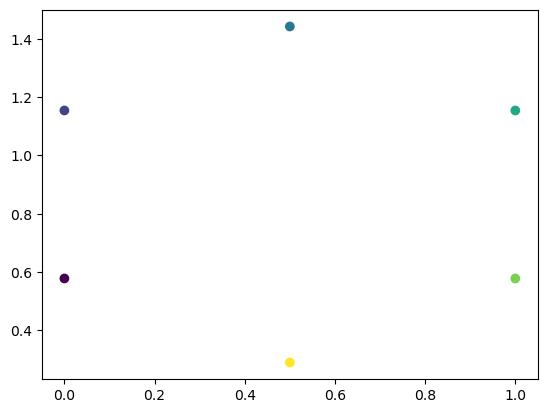

In [ ]:
# checking orientation conventions

#face = np.array([he.vertices[0].coords for he in nghbs[0].hes])
#plt.scatter(*face.T, c=np.arange(face.shape[0]))

cell = np.array([fc.dual_coords for fc in nghbs])
plt.scatter(*cell.T, c=np.arange(cell.shape[0]))

In [ ]:
tns.polygon_perimeter(cell), 2*np.sqrt(3)

(DeviceArray(3.46410162, dtype=float64), 3.4641016151377544)

In [ ]:
iso_dict = v.get_isogonal()
iso_dict

{46: array([-2.        , -1.15470054]),
 47: array([-2.        ,  1.15470054]),
 51: array([1.41410032e-16, 2.30940108e+00]),
 50: array([2.        , 1.15470054]),
 49: array([ 2.        , -1.15470054]),
 48: array([-1.41410032e-16, -2.30940108e+00])}

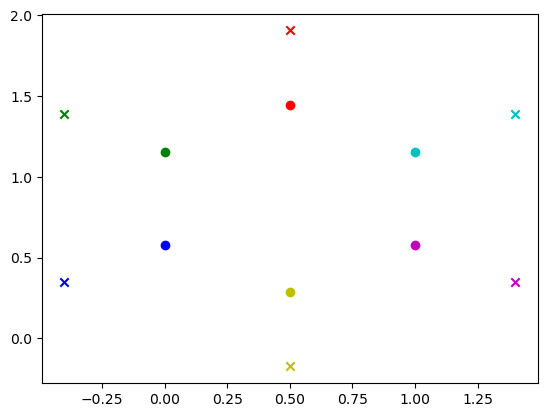

In [ ]:
colors = list(mpl.colors.BASE_COLORS.values())
for c, fc in zip(colors, nghbs):
    plt.scatter(*fc.dual_coords, color=c)
    plt.scatter(*(fc.dual_coords+.2*iso_dict[fc._fid]), color=c, marker='x')


In [ ]:
mesh = msh.get_test_hemesh_large()
mesh.set_voronoi()
print(len(mesh.vertices))

1250


In [ ]:
%%time
iso_dicts = {key: val.get_isogonal() for key, val in mesh.vertices.items()}

# not super fast, but ok.

CPU times: user 676 ms, sys: 0 ns, total: 676 ms
Wall time: 682 ms


In [ ]:
#| export

@patch
def get_isogonal_transform_matrix(self: msh.HalfEdgeMesh, flattened=False) -> NDArray[Shape["*,*,2"], Float]:
    """
    Create a matrix that transforms isogonal modes to vertex displacement
    
    To do the basis conversion, order vertices (cells) and faces (cell vertices) according to their indices.
    
    If flattened, flatten by combining face & x/y-component index
    
    """    
    face_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    vertex_key_dict = {key: ix for ix, key in enumerate(sorted(self.faces.keys()))}
    
    iso_matrix = np.zeros((len(self.vertices), len(self.faces), 2))
    iso_dicts = {key: val.get_isogonal() for key, val in self.vertices.items()}

    for vkey, iso_dict in iso_dicts.items():
        for fkey, dr in iso_dict.items():
            iso_matrix[vertex_key_dict[vkey], face_key_dict[fkey], :] = dr
    if flattened:
        return iso_matrix.reshape((iso_matrix.shape[0], iso_matrix.shape[1]*iso_matrix.shape[2]))
    return iso_matrix

In [ ]:
# timing

mesh = msh.get_test_hemesh_large()
mesh.set_voronoi()
print(len(mesh.vertices))

%time iso_matrix = mesh.get_isogonal_transform_matrix()
print(iso_matrix.shape, np.mean(iso_matrix >0))

# note: very sparse ofc

1250
CPU times: user 673 ms, sys: 11.6 ms, total: 684 ms
Wall time: 684 ms
(1250, 2352, 2) 0.0012


In [ ]:
## testing

mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=.1))
mesh.set_voronoi()

iso_matrix = mesh.get_isogonal_transform_matrix()

iso_matrix.shape

(47, 70, 2)

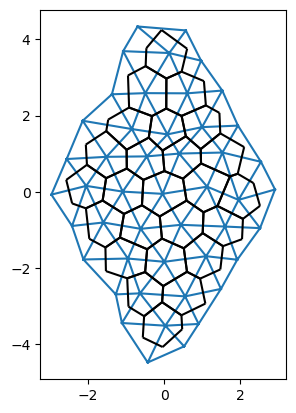

In [ ]:
mesh.triplot()
mesh.cellplot()
plt.gca().set_aspect('equal')

In [ ]:
## test that isogonal modes don't affect the angle penalty

print('pre', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

theta = np.random.normal(scale=.05, size=len(mesh.vertices))
dr = np.einsum('i,ijk', theta, iso_matrix)
x0 = mesh.primal_vertices_to_vector(flattened=False)

new_positions = mesh.vector_to_primal_vertices(x0 + dr, flattened=False)
for key, val in mesh.faces.items():
    val.dual_coords = new_positions[key]

print('mean translation', np.linalg.norm(dr, axis=1).mean())
    
print('post', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

pre 8.276712648580524e-16
mean translation 0.20758328369761322
post 3.793770853022216e-15


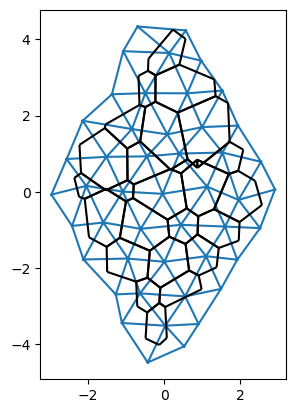

In [ ]:
mesh.triplot()
mesh.cellplot()
plt.gca().set_aspect('equal')

In [ ]:
sorted(list(mesh.get_primal_edge_lens(oriented=True).values()))[:3] # some edge collapses = negative lengths

[-0.20976576967479885, -0.03802586461868229, -0.017968329877702735]

In [ ]:
## check same thing but for "flattened" version to check everything works

mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=.1))
mesh.set_voronoi()
iso_matrix = mesh.get_isogonal_transform_matrix(flattened=True)


print('pre', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

theta = np.random.normal(scale=.05, size=len(mesh.vertices))
dr = theta @ iso_matrix
x0 = mesh.primal_vertices_to_vector(flattened=True)

new_positions = mesh.vector_to_primal_vertices(x0 + dr, flattened=True)
for key, val in mesh.faces.items():
    val.dual_coords = new_positions[key]

print('mean translation', np.linalg.norm(dr.reshape((int(dr.shape[0]/2), 2)), axis=1).mean())
    
print('post', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

pre 9.567346914707263e-16
mean translation 0.23164574341684546
post 1.851546693742983e-14


In [ ]:
# comparing this to a random translation

mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh())
mesh.set_voronoi()
x0 = mesh.primal_vertices_to_vector(flattened=False)

dr_random = np.random.normal(size=(len(mesh.faces), 2), scale=.1)

new_positions = mesh.vector_to_primal_vertices(x0 + dr_random, flattened=False)
for key, val in mesh.faces.items():
    val.dual_coords = new_positions[key]

print('mean translation', np.linalg.norm(dr_random, axis=1).mean())

print('post random', np.quantile(list(mesh.get_angle_deviation().values()), q=.99))

mean translation 0.12117265669762665
post random 0.5067293192602075


## Getting the JAX hessian

Based on code from `03`. Now we don't need the angle penalty ofc!

We write a new energy function here.

We keep the boundary conditions though. Useful to apply forces at tissue boundaries.

In [ ]:
#| export

@jit
def get_E_iso(x0, e_lst_primal, e_dual, cell_list, bdry_list, valence_mask,
              mod_bulk=0, mod_shear=0, shape0=jnp.sqrt(3)*jnp.eye(2),
              mod_area=0, A0=jnp.sqrt(3)/2, mod_perimeter=0, P0=2*jnp.sqrt(3),
              angle_penalty=0, bdry_penalty=0, epsilon_l=1e-3):
    """
    Compute shape-tensor based cell elastic energy with angle & boundary constraint penalties.
    
    For mathematical details about the energy function see paper.
    
    This function relies on the arrays produced by the mesh serialization routine
    get_primal_energy_fct_jax. The first argument is the vector representing
    the primal vertex coordinates, as given by msh.HalfEdgeMesh.primal_vertices_to_vector
    The other required arguments are the serialization arrays. Usage example:
    
    x0 = mesh.primal_vertices_to_vector()
    energy_arrays, cell_ids = mesh.get_primal_energy_fct_jax()
    E = get_E(x0, *energy_arrays, mod_bulk=1)
    
    Parameters, i.e. the pre-factors of the different terms in the elastic energy are
    given by the keyword arguments.
    
    Parameters
    ----------
    x0 : (2*n_cell_vertices) array
        As produced by msh.HalfEdgeMesh.primal_vertices_to_vector
    .... : arrays
        Serialization arrays, see msh.HalfEdgeMesh.get_primal_energy_fct_jax
    mod_bulk, mod_shear, shape0: float
        Moduli and reference shape for shape tensor elasticity
    mod_area, mod_perimetet, A0, Po: float
        Moduli and reference area/perimeter for vertex-model elasticity
    angle_penalty: float
        angle penalty strength
    bdry_penalty: float
        boundary condition strength
    epsilon_l: float
        Regularization for short-length edges, required for differentiability

    Returns
    -------
    float
        Elastic energy + angle & boundary condition penalties
    
    """
    pts = jnp.reshape(x0, (int(x0.shape[0]/2), 2))
    cells = jnp.stack([pts[i] for i in cell_list.T], axis=0)
    
    # area+perimeter elasticity
    areas = tns.polygon_area(cells.transpose((0,2,1)))
    perimeters = tns.polygon_perimeter(cells.transpose((0,2,1)))
    E_vertex = mod_area*jnp.mean((areas-A0)**2) + mod_perimeter*jnp.mean((perimeters-P0)**2)
    
    # face-based shape energy
    edges = cells - jnp.roll(cells, 1, axis=0)
    lengths = jnp.sqrt(jnp.sum(edges**2, axis=-1)+epsilon_l**2)
    # + epsilon**2 to avoid non-differentiable sqrt at 0-length edges (occurs due to padding)
    units = (edges.T/lengths.T).T
    delta = jnp.einsum('efi,efj->fij', edges, units) - shape0
    E_shape = (mod_shear*jnp.mean(jnp.sum(delta**2, axis=(1,2)))
               + mod_bulk*jnp.mean((delta[:,0,0]+delta[:,1,1])**2))
        
    # angle penalty
    e_primal = pts[e_lst_primal[:,1],:] - pts[e_lst_primal[:,0],:] # he.twin.face-he.face
    lengths = jnp.sqrt(jnp.sum(e_primal**2, axis=-1)+epsilon_l**2)
    # + epsilon to avoid 0-division error and make penalty smooth as length passes through 0
    E_angle = angle_penalty*jnp.mean(1-jnp.einsum('ei,ei->e', e_primal, e_dual)/lengths)
    # note: non-zero epsilon creates a "penalty" against 0-length edges 

    # boundary conditions
    E_bdry = 0
    for bdry in bdry_list:
        centroids = (jnp.sum(cells[:,bdry[1]].T*valence_mask[bdry[1]], axis=-1)
                     /jnp.sum(valence_mask[bdry[1]],axis=-1))
        E_bdry = E_bdry + bdry_penalty*jnp.sum(bdry[0](centroids)) # shape (2, n_cells_in_bdry)
    
    return E_vertex + E_shape + E_angle + E_bdry

get_E_iso_jac = jit(jax.grad(get_E_iso))
get_E_iso_hessian = jit(jax.hessian(get_E_iso))

In [ ]:
#| export

@patch
def get_iso_energy_fct_jax(self: iso.CellHalfEdgeMesh, bdry_list=None):
    """Get the relevant subset of serialization arrays"""
    (e_lst_primal, e_dual, cell_list, _, bdry_list, valence_mask), _ = self.get_primal_energy_fct_jax(bdry_list)
    return e_lst_primal, e_dual, cell_list, bdry_list, valence_mask


In [ ]:
#| export

@patch
def optimize_cell_shape(self: iso.CellHalfEdgeMesh, bdry_list=None,
                        energy_args=None, tol=1e-3, maxiter=10000, verbose=True) -> Dict:
    """
    Set primal vertex positions by constrained cell-shape energy optimization.
    
    The parameters for the elastic energy (e.g. moduli) are passed as a dict 'energy_args'.
    bdry_list contains the boundary conditions, as pairs (penalty function, vertex ids).
    Also passes arguments to the scipy optimizer ('tol', 'maxiter')
        
    Parameters
    ----------
    bdry_list: [(penalty function, vertex ids),]
        List of boundaries. None = no boundaries.
    energy_args: Dict
        Dictionary with the parameters to the cell shape elastic energy. See `get_E_iso`.
    tol: float
        Optimizer tolerance
    maxiter: int
        Maximum number of optimizer iterations
    verbose: bool
        Print error messages
    
    Returns
    -------
    None
    
    """
    x0 = self.primal_vertices_to_vector()
    get_E_arrays = self.get_iso_energy_fct_jax(bdry_list)
    
    # set default arguments and convert to list for optimizer
    default_args = {'mod_bulk': 0, 'mod_shear': 0, 'shape0': jnp.sqrt(3)*jnp.eye(2),
                    'mod_area': 0, 'A0': jnp.sqrt(3)/2, 'mod_perimeter': 0, 'P0': 2*jnp.sqrt(3),
                    'angle_penalty': 0, 'bdry_penalty': 0, 'epsilon_l': 1e-3}
    combined = {} if energy_args is None else deepcopy(energy_args)
    for key, val in default_args.items():
        if key not in combined:
            combined[key] = val
    args_list = (combined[key] for key in ['mod_bulk', 'mod_shear', 'shape0', 'mod_area', 'A0',
                                           'mod_perimeter', 'P0', 'angle_penalty', 'bdry_penalty', 'epsilon_l'])
    
    # optimize
    sol = optimize.minimize(get_E, x0, jac=get_E_jac, args=get_E_arrays+args_list,
                             method="CG", tol=tol, options={"maxiter": maxiter})
    
    if sol["status"] !=0 and verbose:
        print("Cell shape optimization failed", sol["message"])
    new_coord_dict = self.vector_to_primal_vertices(sol["x"])
    for key, val in self.faces.items():
        val.dual_coords = new_coord_dict[key]
    return sol

## Testing 

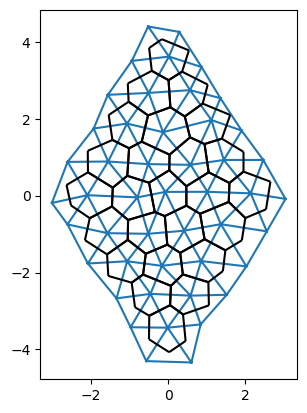

In [ ]:
mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=0.1))
iso_matrix = mesh.get_isogonal_transform_matrix()

mesh.set_voronoi()

mesh.triplot()
mesh.cellplot()
plt.gca().set_aspect('equal')

In [ ]:
x0 = mesh.primal_vertices_to_vector()
energy_arrays = mesh.get_iso_energy_fct_jax()

get_E_iso(x0, *energy_arrays, mod_area=1)

DeviceArray(0.00585392, dtype=float64)

In [ ]:
# check 
areas = np.array([x for x in mesh.get_areas().values() if x is not None])
np.mean((areas -np.sqrt(3)/2)**2)

0.005853924243732083

In [ ]:
# now compute the hessian

hess = get_E_iso_hessian(x0, *energy_arrays, mod_area=1)

hess.shape, iso_matrix.shape

((140, 140), (47, 70, 2))

In [ ]:
# a,b,c =  cells. i,j,k = spatial components (x/y). f,g,h = faces

iso_matrix_flat = mesh.get_isogonal_transform_matrix(flattened=True)

projected_hess = iso_matrix_flat @ hess @ iso_matrix_flat.T

projected_hess.shape

(47, 47)

## Diagonlization, direct & dense

Compute the Hessian -> multiply with matrices to project onto isogonal modes -> diagonalize

Do all of it using direct diag & dense matrices. Later, for large systems, it might be appropriate to use indirect computation of the Jacobian/vector product, sparse matrices to represent the isogonal modes, and iterative diagonalization (e.g. Lanzos).

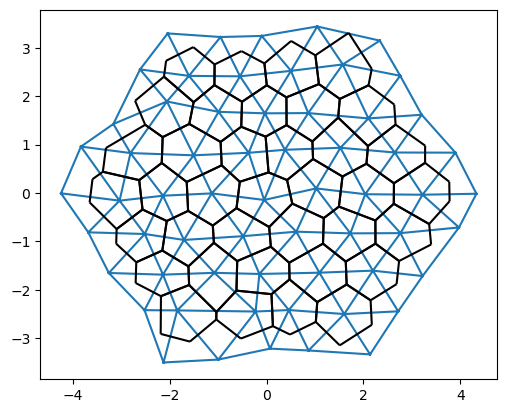

In [ ]:
## triangular lattice with voronoi

mesh = iso.CellHalfEdgeMesh(dln.get_tri_hemesh(noise=0.1, nx=9, ny=9))  #(7,13)  -(15, 19)
mesh.transform_vertices(dln.shear_mat(1.05))
iso_matrix = mesh.get_isogonal_transform_matrix(flattened=False)
iso_matrix_flat = mesh.get_isogonal_transform_matrix(flattened=True)

mesh.set_voronoi()

mesh.triplot()
mesh.cellplot()
plt.gca().set_aspect('equal')

In [ ]:
%%time

x0 = mesh.primal_vertices_to_vector()

hess = get_E_iso_hessian(x0, *energy_arrays, #mod_bulk=1, mod_shear=1,
                        mod_area=1, mod_perimeter=1)
projected = iso_matrix_flat @ hess @ iso_matrix_flat.T
vals, vecs = np.linalg.eigh(projected)

CPU times: user 13.3 ms, sys: 4.12 ms, total: 17.4 ms
Wall time: 14.4 ms


In [ ]:
help(np.linalg.eigh)

Help on function eigh in module numpy.linalg:

eigh(a, UPLO='L')
    Return the eigenvalues and eigenvectors of a complex Hermitian
    (conjugate symmetric) or a real symmetric matrix.
    
    Returns two objects, a 1-D array containing the eigenvalues of `a`, and
    a 2-D square array or matrix (depending on the input type) of the
    corresponding eigenvectors (in columns).
    
    Parameters
    ----------
    a : (..., M, M) array
        Hermitian or real symmetric matrices whose eigenvalues and
        eigenvectors are to be computed.
    UPLO : {'L', 'U'}, optional
        Specifies whether the calculation is done with the lower triangular
        part of `a` ('L', default) or the upper triangular part ('U').
        Irrespective of this value only the real parts of the diagonal will
        be considered in the computation to preserve the notion of a Hermitian
        matrix. It therefore follows that the imaginary part of the diagonal
        will always be treated as zero

In [ ]:
vals.shape, np.mean(vals < 1e-6)

# 100% 0 modes for mod_area = 0, mod_perimeter = 0
# 65% 0 modes for mod_area = 1, mod_perimeter = 0
# 43% 0 modes for mod_area = 0, mod_perimeter = 1
# 48% 0 modes for mod_area = 1, mod_perimeter = 1

# the degeneracy appears for a large mesh! for smaller meshes

((61,), 0.18032786885245902)

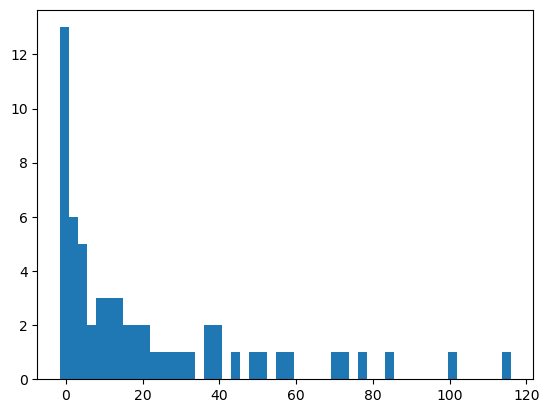

In [ ]:
plt.hist(vals, bins=50);


In [ ]:
## plot the localization!

np.round(100*np.sort(np.abs(vecs[:,0])), decimals=1)

array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0.1,  0.1,  0.1,  0.1,  0.2,  0.2,
        0.3,  0.4,  0.4,  0.5,  1.1,  1.1,  2. ,  2.1,  2.2,  2.3,  2.3,
        2.7,  3. ,  3. ,  3.2,  3.4,  3.6,  3.7,  3.8,  3.9,  5. ,  5.3,
        5.4,  6.3,  6.7,  7.2,  7.9,  7.9,  8.1,  8.5,  9.5, 10. , 10.4,
       10.9, 10.9, 11.3, 11.4, 12.2, 14.6, 15.5, 16.9, 18.3, 19.8, 20.7,
       21.7, 26.4, 27.8, 29.6, 38.4, 47.6])

In [ ]:
#| export

def top_q_share(x, q=.9):
    return np.round(x[x > np.quantile(x, q)].sum() / x.sum(), decimals=2)

In [ ]:
normalized = (vecs.T)**2 / (vecs.T**2).sum(axis=1)

top_q_share(normalized[0], .95), top_q_share(normalized[-1], .95)

(0.46, 0.66)

(array([ 7., 16., 18.,  7.,  2.,  3.,  3.,  0.,  0.,  5.]),
 array([0.17 , 0.253, 0.336, 0.419, 0.502, 0.585, 0.668, 0.751, 0.834,
        0.917, 1.   ]),
 <BarContainer object of 10 artists>)

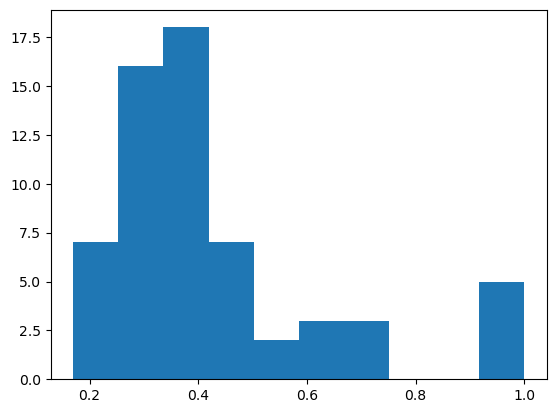

In [ ]:
plt.hist([top_q_share(x, .95) for x in normalized])

In [ ]:


np.abs(vecs[:,0]).shape

(61,)

In [ ]:
help(mesh.vertices_to_vector)

Help on method vertices_to_vector in module CE_simulation.tension:

vertices_to_vector(x0, flattened=True) -> Dict[int, npbase_meta_classes.NDArray] method of CE_simulation.isogonal.CellHalfEdgeMesh instance
    Reverse of vector_to_vertices - format output of energy minimization as dict.



In [ ]:
np.abs(vecs[:,0])

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

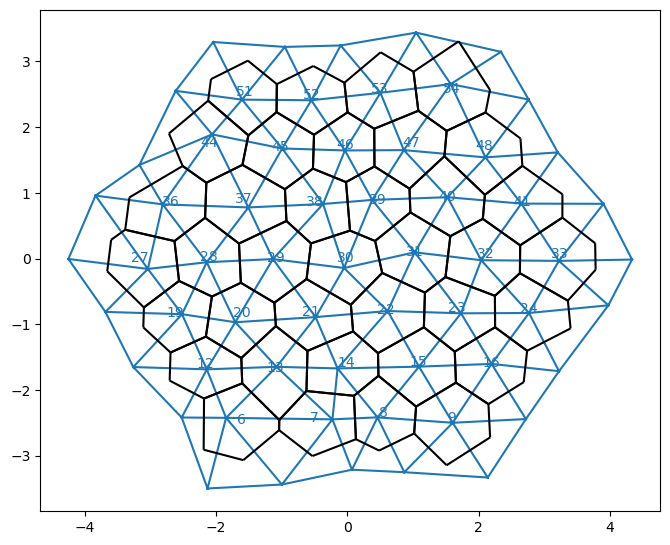

In [ ]:
## spatial plot of shape energies


fig = plt.figure(figsize=(8,8))

plt.gca().set_aspect("equal", adjustable="box")
mesh.cellplot()
mesh.triplot()
mesh.labelplot(face_labels=False, cell_labels=True, vertex_labels=False)

# now calculate the energies and centroids

iso_mode = mesh.vector_to_vertices(np.abs(vecs[:,0]))

for_scttr = np.stack([np.hstack([mesh.vertices[key].get_centroid(), [val]])
                      for key, val in iso_mode.items()], axis=1)
plt.scatter(*for_scttr[:2], c=for_scttr[2], vmin=0, vmax=.4, s=50)

In [ ]:
mesh_new = deepcopy(mesh)

theta = .1 * vecs[:,-1]
dr = np.einsum('i,ijk', theta, iso_matrix)
x0 = mesh_new.primal_vertices_to_vector()

new_positions = mesh_new.vector_to_primal_vertices(x0 + dr)
for key, val in mesh_new.faces.items():
    val.dual_coords = new_positions[key]


In [ ]:
np.linalg.norm(dr, axis=-1).mean() # .035 -> .039

0.03889388005986553

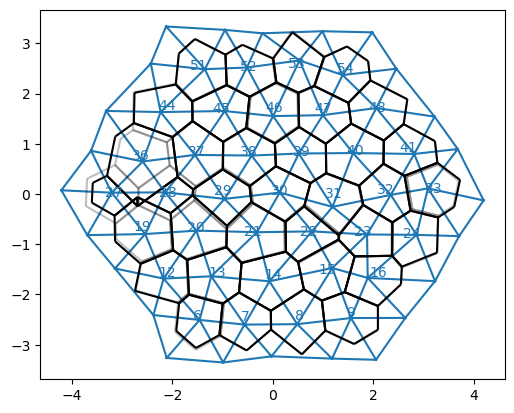

In [ ]:
mesh.cellplot(alpha=.25)

mesh_new.cellplot()
mesh_new.triplot()
mesh_new.labelplot(face_labels=False, cell_labels=True, vertex_labels=False)
plt.gca().set_aspect("equal", adjustable="box")


In [ ]:
x0_pre = mesh.primal_vertices_to_vector()
x0_post = mesh_new.primal_vertices_to_vector()

energy_arrays, _ = mesh_new.get_isogonal_energy_fct_jax()

print('pre iso', get_E_iso(x0_pre, *energy_arrays, mod_area=1, mod_perimeter=1))
print('post iso', get_E_iso(x0_post, *energy_arrays, mod_area=1, mod_perimeter=1))

# .03 -> .06 for lowest mode
# .03 -> .12 for highest mode

# looks like the isogonal modes work roughly as expected.
# the null modes increase energy less than the highest modes.

# presumably we should evaluate this around the minimum.

pre iso 0.030256572244439964
post iso 0.1288664562848233


In [ ]:
help(np.linalg.eigh)

Help on function eigh in module numpy.linalg:

eigh(a, UPLO='L')
    Return the eigenvalues and eigenvectors of a complex Hermitian
    (conjugate symmetric) or a real symmetric matrix.
    
    Returns two objects, a 1-D array containing the eigenvalues of `a`, and
    a 2-D square array or matrix (depending on the input type) of the
    corresponding eigenvectors (in columns).
    
    Parameters
    ----------
    a : (..., M, M) array
        Hermitian or real symmetric matrices whose eigenvalues and
        eigenvectors are to be computed.
    UPLO : {'L', 'U'}, optional
        Specifies whether the calculation is done with the lower triangular
        part of `a` ('L', default) or the upper triangular part ('U').
        Irrespective of this value only the real parts of the diagonal will
        be considered in the computation to preserve the notion of a Hermitian
        matrix. It therefore follows that the imaginary part of the diagonal
        will always be treated as zero

In [ ]:
## test - apply a trafo based on the lowest eigenvec and see whether energy changes